In [1]:
import lime.lime_tabular as lt
import shap as sh

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


**Model construction**

In [2]:
# Download dataset
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
rs = 42  # Random state for reproducibility

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# Model initialization and training
model = RandomForestRegressor(random_state=rs)
model.fit(X_train, y_train)

# Limit test data size for explanations
X_test_min = X_test[:100]

# Сreate a table to store global results
global_expl_tabl = pd.DataFrame()
global_expl_tabl['feature'] = X_test.columns

**SHAP and LIME explainers**

In [14]:
# Initialize SHAP and LIME explainers
shap_explainer = sh.KernelExplainer(model.predict, sh.sample(X_train, 100))
shap_values = shap_explainer.shap_values(X_test_min)
shap_global = shap_values.mean(axis=0)

lime_explainer = lt.LimeTabularExplainer(training_data = X_train.values, mode='regression', feature_names = X_train.columns)
# lime_values = np.array([
#     [e[1] for e in lime_explainer.explain_instance(
#         data_row=row, 
#         predict_fn=model.predict, 
#         num_features=len(X_train.columns)
#         ).as_list()] 
#         for row in X_test_min.values])

lime_values = np.array([
    [e[1] for e in sorted(lime_explainer.explain_instance(
        data_row=row, 
        predict_fn=model.predict, 
        num_features=len(X_train.columns)
        ).as_map()[1], key=lambda x: x[0])] 
        for row in X_test_min.values])

# for row in X_test_min.values:
#     te = lime_explainer.explain_instance(
#         data_row=row, 
#         predict_fn=model.predict, 
#         num_features=len(X_train.columns)
#         )
#     print(te.as_map()[1])
#     for e in te.as_list():
#         print(e[1])


lime_global = np.mean(lime_values * X_test_min.values, axis=0)


# Results compilation
results = pd.DataFrame({
    'feature': X_test.columns,
    'shap_value': shap_global,
    'lime_value': lime_global,
    'lime_coefs': lime_values.mean(axis=0)
})

**Plot**

In [16]:
def plot_lime_shap(data, shap_column, lime_column):
    
    colors = sns.color_palette("deep")
    plt.figure(figsize=(10, 8))    
    
    bar_positions = np.arange(len(data))  # Positions of the bars
    bar_width = 0.35  # Bar widths

    plt.barh(bar_positions - bar_width/2, data[shap_column], height=bar_width, label='SHAP', color=colors[0])  # PSHAP values
    plt.barh(bar_positions + bar_width/2, data[lime_column], height=bar_width, label='LIME', color=colors[1])  # LIME values
    plt.yticks(bar_positions, data['feature'])  #labels

    plt.title('Feature Importances from SHAP and LIME')
    plt.legend()
    plt.show()

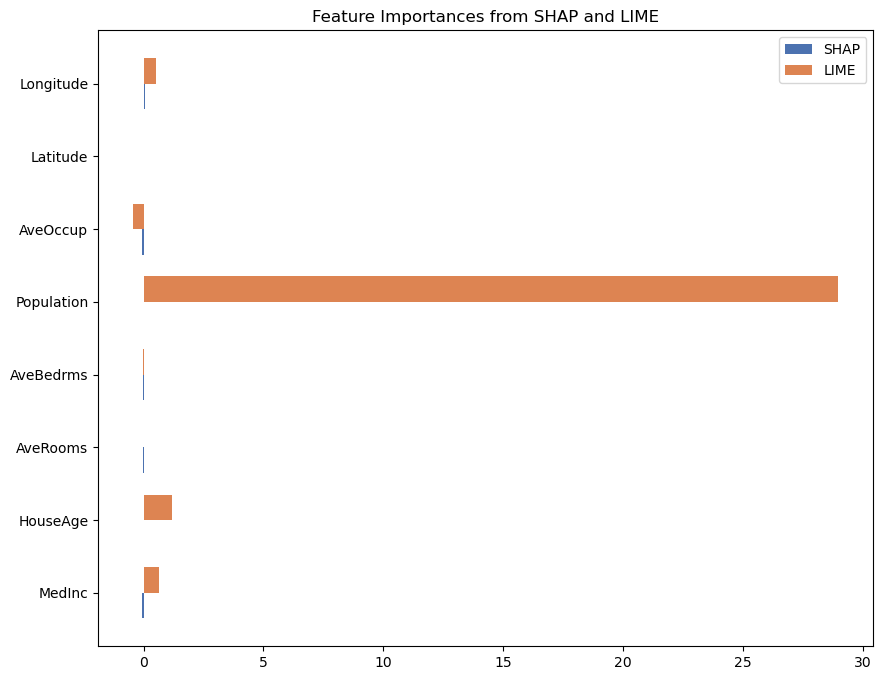

In [17]:
plot_lime_shap(results, 'shap_value', 'lime_value')

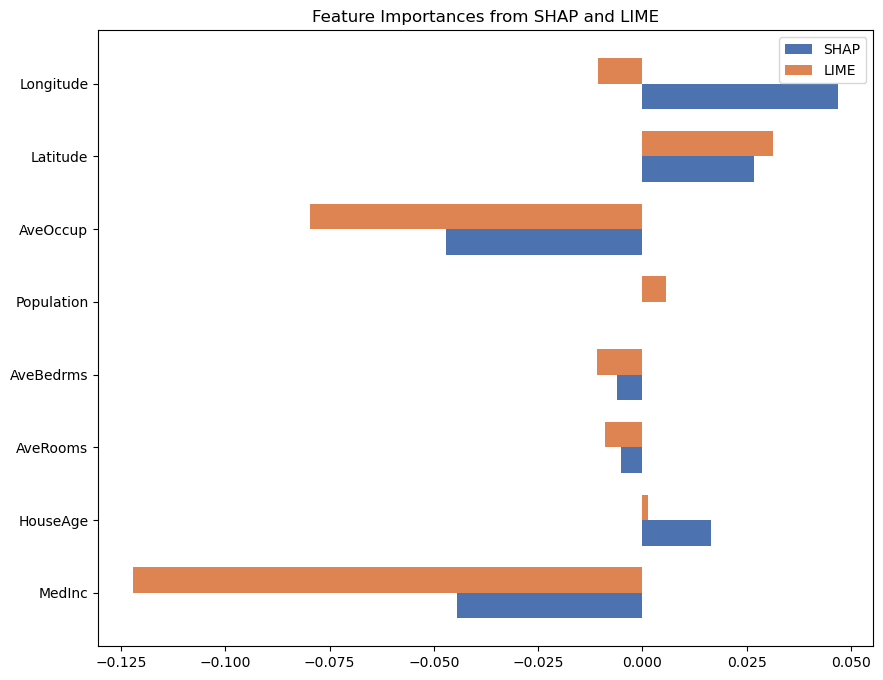

In [18]:
plot_lime_shap(results, 'shap_value', 'lime_coefs')